# Analyzing tau with different methods (low-phase, HG params) (3-region)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
if '..' not in sys.path: sys.path.append('..')
from f_ring_util import (compute_corrected_ew, 
                         compute_corrected_ew_col,
                         fit_hg_phase_function, 
                         hg_func,
                         print_hg_params)
pd.set_option('display.max_rows', None)

# analyze_tau version that only applies tau correction to core range (but, includes all points in optimization)

In [2]:
# Define functions to process data

def remove_eqx(orig_obsdata, eqx_cutoff):
    #remove EQX observations
    #orig_obsdata: original pandas dataframe
    #returns: obsdata (EQX observations removed)
    
    good_i = np.abs(orig_obsdata['Incidence']-90) > eqx_cutoff
    obsdata = orig_obsdata[good_i]
    print('Removed EQX OBSIDs:', set(orig_obsdata[~good_i].groupby('Observation').indices))
    print('Unique observation names:', len(obsdata))
    print()
    
    return obsdata

def remove_outliers(obsdata, outlier_obs):
    #remove 3 outliers from ~phase 50-60 before fitting for tau
    #(located by hand, removing from all 3 by observation name)
    
    for obsid in outlier_obs:
        #drop row containing outlier ob
        obsdata = obsdata[obsdata.index != obsid]
            
    print('Removed outlier OBSIDs:', outlier_obs)
    print('Unique observation names:', len(obsdata))
    print()
    return obsdata

In [20]:
# Define other functions

# optimize for best-fit tau, low-phase method
def optimize_tau_lp(obsdata):
    
    # Find "small" (<6) e or i
    low_phase_mask = obsdata['Mean Phase'] <= 60
    low_phase_obsdata = obsdata[low_phase_mask]
    lp_low_e_mask = np.abs(low_phase_obsdata['Mean Emission']-90) < 6
    lp_low_i_mask = np.abs(low_phase_obsdata['Incidence']-90) < 6
    lp_low_ei_mask = lp_low_e_mask | lp_low_i_mask

    low_e_mask = np.abs(obsdata['Mean Emission']-90) < 6
    low_i_mask = np.abs(obsdata['Incidence']-90) < 6
    low_ei_mask = low_e_mask | low_i_mask
    
    print(low_phase_obsdata.shape)
    
    best_tau = None
    best_slope = 1e38
    for tau in np.arange(0.000, 0.101, 0.001):

        #get the tau-adjusted EW values for the core/Region 2
        corrected_ew = compute_corrected_ew_col(low_phase_obsdata, col_tau=('Normal EWI', None, \
                                                                            'Normal EWC', tau, \
                                                                            'Normal EWO', None)) 

        coeff = np.polyfit(low_phase_obsdata['Mu0'], corrected_ew, 1)
        if abs(coeff[0]) < best_slope:
            best_slope = abs(coeff[0])
            best_tau = tau
        #print(f'Tau {tau:.3f} - Slope: {coeff[0]:8.5f}')

    print()
    print(f'** Best Tau: {best_tau:.3f}')
    
    return best_tau


    
# optimize for best-fit tau, HG param method
def optimize_tau_hg(obsdata, nstd=None):
    best_tau = None
    best_std = 1e38
    for tau in np.arange(0.000, 0.101, 0.001):
        hg_params, hg_used_data, hg_std = fit_hg_phase_function(2, nstd, obsdata, col_tau=('Normal EWI', None, \
                                                                                            'Normal EWC', tau, \
                                                                                            'Normal EWO', None))

        if hg_std < best_std:
            best_std = hg_std
            best_tau = tau

    print()
    print(f'** Best Tau: {best_tau:.3f}')
    return best_tau


def phase_curve(hg_used_data, phase_col, uc_ew_col, ew_col, hg_params, best_tau, outlier_obs=None):
    
    if outlier_obs:
        outliers = hg_used_data[hg_used_data.index.isin(outlier_obs)]
        #outliers = hg_used_data.drop(outlier_obs)
    
    plt.figure(figsize=(10,3))

    #plot the uncorrected points
    plt.subplot(1, 2, 1)        
    plt.scatter(hg_used_data[phase_col], hg_used_data[uc_ew_col], c='midnightblue')
    if outlier_obs:
        plt.scatter(outliers[phase_col], outliers[uc_ew_col], c='lightcoral', edgecolors='black')
    plt.xlabel('Phase Angle (°)')
    plt.ylabel('Normal EW')
    plt.title('Normal EW vs. Phase Angle (uncorrected)')

    #plot the corrected points + model
    plt.subplot(1, 2, 2)
    plt.scatter(hg_used_data[phase_col], hg_used_data[ew_col], c='midnightblue')
    if outlier_obs:
        plt.scatter(outliers[phase_col], outliers[ew_col], c='lightcoral', edgecolors='black')
    #plot the phase curve
    xrange = np.arange(hg_used_data[phase_col].min(), hg_used_data[phase_col].max()+1)
    hg_phase_model = hg_func(hg_params, xrange)
    plt.plot(xrange, hg_phase_model, '-', color='tab:red', lw=2, label='Phase model')
    
    plt.xlabel('Phase Angle (°)')
    plt.ylabel('Normal EW')
    plt.title(f'Normal EW vs. Phase Angle\n(corrected), best tau ={best_tau}')
    plt.show()

In [4]:
# Define variables

# directory of dumped EW csv files
dump_ew_dir = '/Users/mlessard/REU_2022/data/dump_ew_csv/'

#use all 3 regions, 4 boundaries between the regions
radii = ['139470', '140170', '140265', '140965']

size = '0' #slice/step size of the csv file

#degrees within 90 (incidence angle) to cut off/get rid of observations
eqx_cutoff = 1.5

#define nstd for the HG param method
nstd = None

#remove outliers? (applies to both low-phase and HG param method)
rm_outliers = False

#list outlier obsids
outliers = ['ISS_091RF_FMOVIE003_PRIME', 'ISS_107RF_FMOVIE002_PRIME', 'ISS_189RF_FMOVIE001_PRIME']
outliers = outliers + ['ISS_041RF_FMOVIE002_VIMS', 'ISS_108RF_FMOVIE001_PRIME', 'ISS_039RF_FMOVIE001_VIMS'] #105 outliers
outliers = outliers + ['ISS_041RF_FMOVIE001_VIMS', 'ISS_043RF_FMOVIE001_VIMS', 'ISS_044RF_FMOVIE001_VIMS'] #85 outliers
#"spike" outliers for 1-degree HG param phase curve:
#outliers = outliers + ['ISS_036RF_FMOVIE001_VIMS']  #160 phase spike
#outliers = outliers + ['ISS_196RF_FMOVIE006_PRIME'] #150 phase spike
#outliers = outliers + ['ISS_039RF_FMOVIE002_VIMS']  #~130 phase spike
#outliers = outliers + ['ISS_036RF_FMOVIE002_VIMS','ISS_196RF_FMOVIE005_PRIME'] #130-133 phase spike 

In [5]:
#get the full-width image data
full_img_filepath = f'{dump_ew_dir}ew_stats_widths_{radii[0]}_{radii[1]}_{radii[2]}_{radii[3]}_{size}.csv'
full_orig_obsdata = pd.read_csv(full_img_filepath, parse_dates=['Date'], index_col='Observation'); ms=20; alpha=0.7

#calculate mu, mu0 
full_orig_obsdata['Mu'] = np.abs(np.cos(np.radians(full_orig_obsdata['Mean Emission'])))
full_orig_obsdata['Mu0'] = np.abs(np.cos(np.radians(full_orig_obsdata['Incidence'])))

In [6]:
#print initial statistics
print('** SUMMARY STATISTICS **')
print('Unique observation names:', len(full_orig_obsdata.groupby('Observation')))
print('Total slices:', len(full_orig_obsdata))
print('Starting date:', full_orig_obsdata['Date'].min())
print('Ending date:', full_orig_obsdata['Date'].max())
print('Time span:', full_orig_obsdata['Date'].max()-full_orig_obsdata['Date'].min())
print()

print(full_img_filepath)
print()

** SUMMARY STATISTICS **
Unique observation names: 151
Total slices: 151
Starting date: 2004-06-20 20:03:28
Ending date: 2017-09-06 11:47:07
Time span: 4825 days 15:43:39

/Users/mlessard/REU_2022/data/dump_ew_csv/ew_stats_widths_139470_140170_140265_140965_0.csv



In [7]:
#remove EQX observations
removed_eqx_obsdata = remove_eqx(full_orig_obsdata, eqx_cutoff)

if rm_outliers:    
    #remove outliers
    obsdata = remove_outliers(removed_eqx_obsdata, outliers)
else:
    obsdata = removed_eqx_obsdata

Removed EQX OBSIDs: {'ISS_112RF_FMOVIE002_PRIME_1', 'ISS_111RF_FMOVIE002_PRIME', 'ISS_112RF_FMOVIE002_PRIME_2', 'ISS_114RF_FMOVIEEQX001_PRIME', 'ISS_115RF_FMOVIEEQX001_PRIME', 'ISS_110RF_FMOVIE002_PRIME'}
Unique observation names: 145



In [8]:
# Calculate best-fit tau with each method

best_tau_lp = optimize_tau_lp(obsdata)
best_tau_hg = optimize_tau_hg(obsdata)

(43, 66)

** Best Tau: 0.048
Ratio min -0.1333657914690496 Max 0.19118488531538622 Sigma 0.05445516809468047
Ratio min -0.13280372582327674 Max 0.19099127852980002 Sigma 0.05431849528744258
Ratio min -0.1322407298173228 Max 0.1907945961313066 Sigma 0.05418559345663229
Ratio min -0.13167510347365513 Max 0.19059882201037254 Sigma 0.0540571443386335
Ratio min -0.13110789392323255 Max 0.19040152186916204 Sigma 0.05393287456936137
Ratio min -0.1305391234779462 Max 0.19020265635591344 Sigma 0.05381286382243708
Ratio min -0.12996802349865602 Max 0.19000406572545667 Sigma 0.05369746950768302
Ratio min -0.12939540095645097 Max 0.18980385157033597 Sigma 0.05358649194979145
Ratio min -0.12882169188624207 Max 0.18960095624666481 Sigma 0.05347985651953808
Ratio min -0.1282450025628698 Max 0.1893999786208084 Sigma 0.05337831880621891
Ratio min -0.12766684320698515 Max 0.18919729152544218 Sigma 0.05328141940297703
Ratio min -0.12708706569028433 Max 0.18899326243576428 Sigma 0.053189285964103286
Ratio

# Plot phase curve (low-phase method)

/var/folders/qk/hcd2p1bs6tx9j0t2rkvc281w0000gn/T/ipykernel_92567/4262424914.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obsdata['Total C EW LP'] = compute_corrected_ew_col(obsdata, col_tau=('Normal EWI', None,


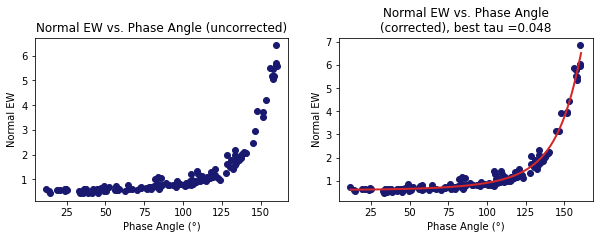

In [9]:
obsdata['Total C EW LP'] = compute_corrected_ew_col(obsdata, col_tau=('Normal EWI', None,
                                                        'Normal EWC', best_tau_lp,
                                                        'Normal EWO', None))
hg_params_lp, hg_used_data_lp, hg_std_lp = fit_hg_phase_function(2, None, obsdata, col_tau=('Total C EW LP', None),
                                                        verbose=False)

phase_curve(hg_used_data_lp, phase_col='Mean Phase', uc_ew_col='Normal EW',\
            ew_col='Total C EW LP', hg_params=hg_params_lp, best_tau=best_tau_lp)

# Plot phase curve (HG param method)

/var/folders/qk/hcd2p1bs6tx9j0t2rkvc281w0000gn/T/ipykernel_92567/1675011848.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obsdata['Total C EW HG'] = compute_corrected_ew_col(obsdata, col_tau=('Normal EWI', None,


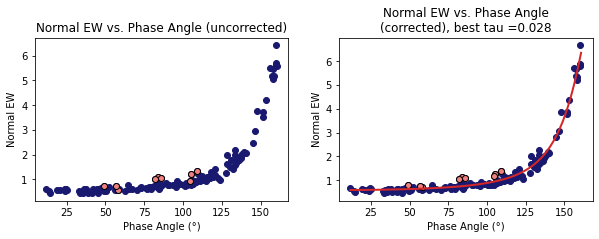

In [21]:
obsdata['Total C EW HG'] = compute_corrected_ew_col(obsdata, col_tau=('Normal EWI', None,
                                                        'Normal EWC', best_tau_hg,
                                                        'Normal EWO', None))
hg_params_hg, hg_used_data_hg, hg_std_hg = fit_hg_phase_function(2, None, obsdata, col_tau=('Total C EW HG', None),
                                                        verbose=False)

phase_curve(hg_used_data_hg, phase_col='Mean Phase', uc_ew_col='Normal EW',\
            ew_col='Total C EW HG', hg_params=hg_params_hg, best_tau=best_tau_hg, outlier_obs=outliers)

# Plot phase curve (pre-calculated columns, HG method in create_ews)

In [ ]:
plt.figure(figsize=(10,3))

#plot the uncorrected points
plt.subplot(1, 2, 1)
plt.scatter(obsdata['Mean Phase'], obsdata['Normal EW'], c='midnightblue')
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
plt.title('Normal EW vs. Phase Angle (uncorrected)')

#plot the corrected points + model
plt.subplot(1, 2, 2)
plt.scatter(obsdata['Mean Phase'], obsdata['Normal EW3Z'], c='midnightblue')
    
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
plt.title(f'Normal EW vs. Phase Angle\n(corrected), automatic')
plt.show()